 # Timeseries Forecasting with LSTM

 In this notebook we will use an LSTM based neural network model to forecast a time-series from a real-world dataset.
 As an example, we use the number of searches for the "common cold" until end of December 2019. We exclude any further data since the search for this term is heavily influenced by the global pandemic caused by SARS-Covid-19.
This has such a profound impact that we cannot expect a neural network based on the number of searches for the previous years to be able to replicate this drastic change in behaviour.

We will query [Google Trends](https://trends.google.com/trends/?geo=US) directly to access the relevant data. Unforuntately, Google does not provide an API which we can use to obtain the data directly. The package ```pytrends``` however wraps Google's web-service as if an API was provided.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import layers

# access Google Trend API
#(pip magic used in Google's colaboratory as not avaiable by default)
!pip install pytrends
from pytrends.request import TrendReq

%pylab inline
# large figures
rcParams['figure.figsize'] = 8, 6

  Created wheel for pytrends: filename=pytrends-4.7.2-cp36-none-any.whl size=14261 sha256=30699aa73751909205968d92d0054033ea42622d46b54f18a04b9dfec5b8e2bf
  Stored in directory: /root/.cache/pip/wheels/64/ae/af/51d48fbbca0563036c6f80999b7ce3f097fa591fd165047baf
Successfully built pytrends
Populating the interactive namespace from numpy and matplotlib


# Obtain the Data

we now use the package ```pytrends``` to obtain the search volume for the years 2016-2019 from Google trends.

In [0]:
# look for common cold globally, no Corona time
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ["Common Cold"]
pytrends.build_payload(kw_list, cat=0, timeframe='2004-01-01 2019-12-31', geo='', gprop='')
#pytrends.build_payload(kw_list, cat=0, geo='', gprop='')
df = pytrends.interest_over_time()
y_orig=df['Common Cold']


Let's have a quick look at the dataframe we obtained and plot the data

The query returns the number of searches aggregated to a monthly level, i.e. each data-point describes the number of queries in one month.

In [6]:
y_orig

date
2004-01-01    88
2004-02-01    88
2004-03-01    68
2004-04-01    68
2004-05-01    57
              ..
2019-08-01    38
2019-09-01    59
2019-10-01    58
2019-11-01    61
2019-12-01    72
Name: Common Cold, Length: 192, dtype: int64

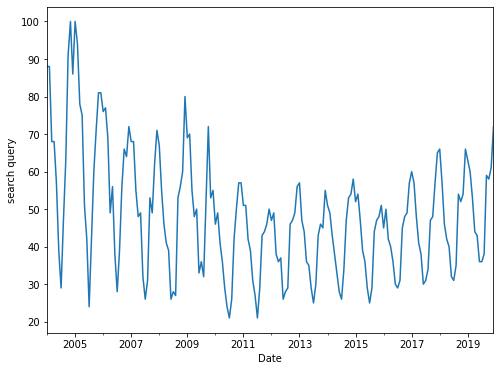

In [7]:
y_orig.plot()
plt.xlabel('Date')
plt.ylabel('search query')
plt.show()

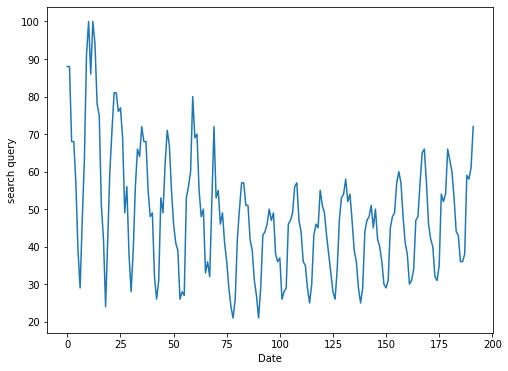

In [8]:
#
# we just need the number of searches for the network model
# and hence remove the date-time index
# When we now plot the data we notice that there is just an index 
# on the x-axis instead of the date.
#
y = y_orig.values.reshape(-1,1)
plt.plot(y)
plt.xlabel('Date')
plt.ylabel('search query')
plt.show()

Transform data
We now need to transform the data in to a sliding window of a fixed width. One key feature of sequences is that the data points are auto-correlated which means that the sequence of the data points matters. In "normal" supervised learning approaches we would shuffle the training data and reserve a fraction chosen at random as the test data. In the case of time-series data, we cannot do this as the sequence of the data points is a key aspect of the structure of a time-series.

LSTM networks are a supervised training network where we predict a label (y_train) from a number of training data (x_data). In our case we take a part of the original training data by considering only a number n points at the time and then predict the next element that would follow immediately after this sequence of n points. Then we shift the window by one time-step (or data point), consider the next window of n data-points and predict the one following the the new sequence and repeat the process until we have processed the complete time-series.

Note that the first sequence of n points is used to create the first element of the sequence of the training targets y_train.

We also need to determine the length of the sequence. In this example we will use 50 points to approximately capture one period of the signal.

In [0]:
##
## transform data into a sliding window of n points each
##

# use 15 points for the window width which is a bit wider than the 12 month period
# from montly data
sequence_length = 15 
sequence = []
for index in range(len(y) - sequence_length):
  sequence.append(y[index: index + sequence_length +1])
  
sequence = np.array(sequence)

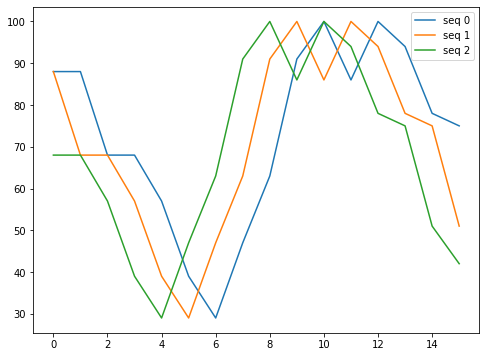

In [10]:
plt.plot(sequence[0], label='seq 0')
plt.plot(sequence[1], label='seq 1')
plt.plot(sequence[2], label='seq 2')

#one towards the end
#seq_no = len(sequence)-int(len(sequence)/10.0)
#plt.plot(sequence[seq_no], label='seq '+ str(seq_no))

plt.legend()
plt.show()

We now split the sequences into a training and test dataset where
we use 80% of the data for training and retain 20% as an independent 
test sample. Since the data points are auto-correlated, we cannot take a random sample but need to take the last 20% of the data.
First we calculate the appropriate index to split the sequences into a training and test sample.

We then take the series of n data-points as the training data (x_train) and the next element in the series as the trainig target (y_train).

Finally, we need to bring the training and test data (x_train and x_test) into the shape expected by the LSTM network. The LSTM layers expect a three-dimensional tensor as input, where the elements specify:
   * the number of samples
   * the length of the sequence
   * the number of forecast steps. In our case we train the model to predict the element directly following the sequence and hence we set this to 1.

In [11]:
#split train/test
train_index = int(round(0.8 * len(sequence)))
print('train index {}'.format(train_index))

train = sequence[:train_index, :]
x_train = train[:, :-1]
y_train = train[:, -1]
x_test  = sequence[train_index:, :-1]
y_test  = sequence[train_index:, -1]

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

print(x_train.shape)

train index 142
(142, 15, 1)


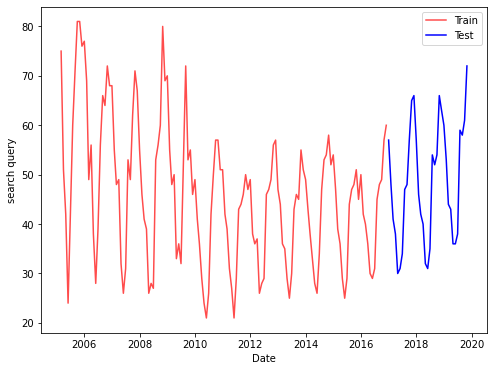

In [12]:
#
# plot train and test data
# (use the original dates in the y dataframe as x-values to get the dates on the x-axis right)
#
#use the original dataframe y_orig for setting the right indices. note that the first sequence is made to create the first target, i.e. sequence[0] -> y[0]

plt.plot(y_orig[sequence_length-1:train_index+sequence_length-1].index , y_train,  label='Train',  color='red', alpha=0.7)
plt.plot(y_orig[sequence_length-1+train_index:sequence_length-1+train_index+len(y_test)].index, y_test, label='Test', color='blue')
plt.xlabel('Date')
plt.ylabel('search query')
plt.legend()
plt.show()

We now build a simple LSTM module with 50 nodes in the input layer and 100 nodes in the hidden layers. We also add a Dropout regularization after each LSTM layer.

Note that we need to specify the parameter ```return_sequences=True``` for each LSTM layer that is followed by another LSTM layer. This ensures that the full sequence of data-points is returned and can be processed by the next layer.

We use the mean squared error (MSE) as loss function, a batch size of just 2 samples and the Adam optimizer with default values to determine the best parameters of the network.

In [37]:
##
### build the model
###

model = tf.keras.Sequential()

model.add(layers.LSTM(units=50, input_shape=(x_train.shape[1],1), return_sequences=True ))
model.add(layers.Dropout(0.2 ))
model.add(layers.LSTM(units=100, return_sequences=True))
model.add(layers.Dropout(0.2 ))
model.add(layers.LSTM(units=100, return_sequences=False))
model.add(layers.Dropout(0.2 ))
model.add(layers.Dense(units=1))
model.add(layers.Activation('linear'))

model.compile(loss='mse', optimizer='adam')

###
### fit model
###
history = model.fit(x_train,y_train, batch_size=1, epochs=500, validation_split=0.05)

Epoch 1/500
134/134 [==============================] - 2s 15ms/step - loss: 1239.6183 - val_loss: 637.5742
Epoch 2/500
134/134 [==============================] - 1s 8ms/step - loss: 647.6151 - val_loss: 330.0011
Epoch 3/500
134/134 [==============================] - 1s 8ms/step - loss: 388.6796 - val_loss: 193.5822
Epoch 4/500
134/134 [==============================] - 1s 8ms/step - loss: 279.6207 - val_loss: 145.9372
Epoch 5/500
134/134 [==============================] - 1s 8ms/step - loss: 235.1724 - val_loss: 133.0353
Epoch 6/500
134/134 [==============================] - 1s 8ms/step - loss: 218.7559 - val_loss: 132.1581
Epoch 7/500
134/134 [==============================] - 1s 8ms/step - loss: 203.5796 - val_loss: 134.1953
Epoch 8/500
134/134 [==============================] - 1s 8ms/step - loss: 203.3059 - val_loss: 136.7750
Epoch 9/500
134/134 [==============================] - 1s 8ms/step - loss: 209.6758 - val_loss: 138.0347
Epoch 10/500
134/134 [==============================]

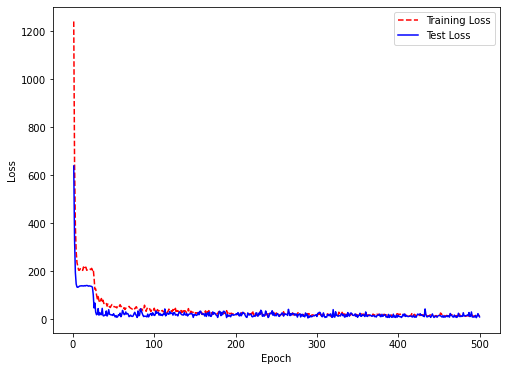

In [38]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

## Predictions on Test Data

We now use the independent test data that we have retained earlier to validate the network.
We start with the first sequence in the test data comprising of n consequtive data points and then predict the next point.
Then we add this prediction to the sequence and move the prediction window one step ahead and predict the next point. We keep iterating this approach until we have processed the complete test data.

In [0]:
# start from the first window in the test data, i.e. sequence_length number of points
# with shape (sequence_length,1)
current_window = x_test[0]
prediction = []

for i in range(len(x_test)):
    #LSTM cell expects 3D shape, add a new axis
    data_point = current_window[np.newaxis,:,:]
    
    #get a single number from the returned shape as the prediction
    pred = model.predict(data_point)[0,0]
    prediction.append(pred)
    # print(pred)
    
    #advance the input window to the LSTM cell, move the sequence one step up, add the prediction as the last number
    current_window = current_window[1:]
    current_window = np.insert(current_window,[sequence_length-1-1], values=prediction[-1], axis=0)

The resulting prediction shows room for improvement...
You can use this as a starting point to experiment with the model and the training.

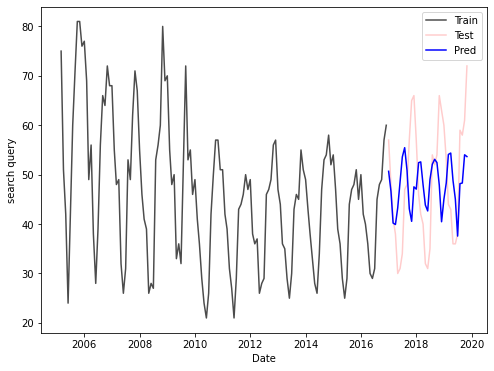

In [47]:
#use the original dataframe y_orig for setting the right indices. note that the first sequence is made to create the first target, i.e. sequence[0] -> y[0]

# "-1" as indices start from 0
plt.plot(y_orig[sequence_length-1:train_index+sequence_length-1].index , y_train,  label='Train',  color='black', alpha=0.7)
plt.plot(y_orig[sequence_length-1+train_index:sequence_length-1+train_index+len(y_test)].index, y_test, label='Test', color='red', alpha=0.2)
plt.plot(y_orig[sequence_length-1+train_index:sequence_length-1+train_index+len(y_test)].index, prediction, label='Pred', color='blue')
plt.xlabel('Date')
plt.ylabel('search query')
plt.legend()
plt.show()

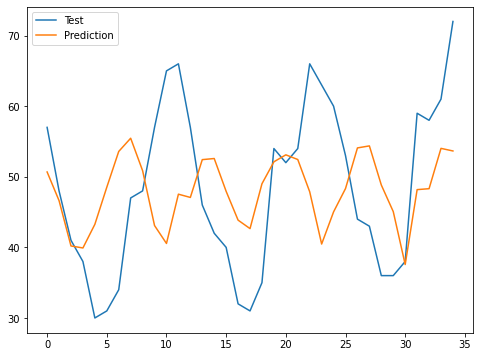

In [48]:
#closeup on the test sample
plt.plot(y_test, label='Test')
plt.plot(prediction, label='Prediction')
plt.legend()
plt.show()